# Assignment
##Task
- Build, train, and evaluate a RNN using Pytorch.
- The RNN should have a minimum of 2 hidden layers.
- Experiment with at least 3 different variations of hyperparameters (e.g., number of layers/neurons, activation functions, epochs learning rates, etc.).

##The assignment should include the following steps:
1. Feature Selection
2. Feature Engineering (if necessary)
3. Standard ML Preprocessing (if necessary)
4. Train-Test Split
5. Defining a Neural Network Architecture in Pytorch
6. Defining a Training Loop
7. Training the Model
8. Experimenting with Different Hyperparameters
9. Evaluating the Final Model on the Test Data

##Data
- Dataset: Tesla (TSLA) Stock Market Data
- Source: Use Yahoo Finance or similar to download the dataset.

##Delivery
- Create a GitHub repository.
- Save the Colab notebook in the repository.
- Provide a README.md with a brief description of the assignment.
- Submissions can be made in groups of up to 3 members.
- Submit the assignment by sending an email with the link to the repository to Hamid (hamidb@business.aau.dk).

#RNN in general and in the context of this analysis
This analysis is made with the purpos of predicting Teslas stock prices using RNN. RNN is used on the time series data since it has the ability to capture sequential dependencies meaning that we try to pridict the closing price using past values. From the lecture we are taught that were a Simple neural network is unidirectional meaning it goes one way from input to output, RNN preserves the information therefore using past information or values. The picture from the lecture shows this as:

<img src="https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/FNN-RNN.png" width="500">

The structure of RNN involves a Linear Part which captures the hidden state which is information from previous time steps, and is hidden in the training part to ensure new predictions for the unseen data, in general it can though be described as a summary of past inputs.

The non linear part involves the activation function which finds the current hidden state using the previous hidden state, the current input and weight matrices.

In the end we can find the fully connected part which calculates the output vector at the timestamp t, meaning the predicted output. This is what we will try to accomplish in the code below

###Packages
We import the necessary packages used in the RNN example from the lectures

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

###1. Feature selection
Here we are using the code from the exercise 1 to get the last 5 years of Tesla stock market data. From there we specify to only keeping the closing stock price of each data.

In [ ]:
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)  # Last 5 years
df = yf.download('TSLA', start=start_date, end=end_date)
df = df[['Close']]
df = df.sort_index()

[*********************100%***********************]  1 of 1 completed


Price                          Close
Ticker                          TSLA
Date                                
2019-11-13 00:00:00+00:00  23.073999
2019-11-14 00:00:00+00:00  23.290001
2019-11-15 00:00:00+00:00  23.478001
2019-11-18 00:00:00+00:00  23.332666
2019-11-19 00:00:00+00:00  23.968000

We are focussing on the closing price to reduce the noise and complaxity of the model, to only find patterns directly related to the prediction of the closing price. The 5 year horiztion gives a karger time horizon given us a relevant amount of data since seasonal patterns can occur in time series data. Sorting the data by index insures the data is cronological making sure the past value used in the calculations is the correct.

###2. Feature Engineering
Here we will further modify our code for time series analysis, this we do by introducing lags and rolling features into the dataset. This will increase the model ability to make predictions and be able to capture more aspects and tendencies.


In [ ]:
# Step 2: Create Lag and Rolling Features
df['lag_5'] = df['Close'].shift(5)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_sd_10'] = df['Close'].rolling(window=10).std()
# df['rolling_diff_10'] = df['Close'] - df['rolling_mean_10']
df.dropna(inplace=True)

By implementing up to 5 days of previous prices through lags, there can be antoher input into the model gained by having historical data and information that can help predict future prices. This will also help find temporal patterns that can occur.

Rolling metrics gives the advantage of capturing trends by using rolling mean to smooth the short term fluctuations to strenghten the focus on long term trends, thereby reducing noice of the daily data.

Next is Rolling standard deviation taht will consider the volatility of the stock price over periods, that captures the uncertainty of the market trends.

**Overall**: These inputs will increase the predictive ablility of the model by taking past values into the prediction of future values, therefore reducing uncertainty of potential trends, volatility and patterns.

###3. Standard ML Preprocessing (if necessary)

Here we standardize the data to make it consistant across the features.

In [ ]:
# Step 3: Normalize the Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

Normalizing the data will keep consistency throughout the data and blocks the option of a single feature to dominate the influence in the model. This will furthermore reduce potential biases in the model. The result of normalizing is that is will prevent numerical issues and give better balance of features and weights.

###4. Train-Test Split

To setup the model, training is needed and will be done with a 20%/80% split.

In [ ]:
# Step 4: Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

Here we seperate the data to train the data and see how the model will persom on untrained data, this will allow us to evaluate the model for accuracy and overfitting the the model. This is the first layer to reevaluate the model incase of bad performance and introcude fixes to get reliable resuls. This step is also nessesary for being able to use hyperparameter tuning to compare the models performances.

###5. Defining a Neural Network Architecture in Pytorch

Here the code will setup the data for deep learning for time series data inputs.

In [ ]:
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 1
n_features = data_scaled.shape[1]  # Number of features
target_column_index = 0  # Target column index (predicting 'Close')

# Create sequences
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

This part will split the multivariate time series data into pairs of input and outputs to train, by setting inputs (x) and a target output (y) that is also the next step, therefore creating a sequencial form n steps ahead. This allows to learn from the past values in the data to predict future values. The sequencial structure allows the model to be used with RNN and LSTM for efficient training.

###6. Defining a Training Loop

This is the setup of the RNN model for time series data predictions.

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Output from the last time step
        out = self.fc(out)
        return out

# Instantiate the model
input_size = n_features
hidden_size = 50
output_size = 1
model = RNNModel(input_size, hidden_size, output_size)

# Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

This part of thge code will setup the RNN with specific parameters and then use "forward" to specify the input data in the model. THis allows the RNN model to learn time series patterns and how temporal features can be used for forecasting predictions where multiple shorter and longer trends influence the data. From there a loss and optimizer function is set up, where MSE is used to reduce errors for the data and Adam is udes to optimize the learning rate of the model.

### 7. Training the Model

For this part the model will be trained and evalutated at the epochs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation Loss
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item()
    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/10, Train Loss: 0.003145, Valid Loss: 0.060697
Epoch 4/10, Train Loss: 0.003421, Valid Loss: 0.066390
Epoch 6/10, Train Loss: 0.003305, Valid Loss: 0.064415
Epoch 8/10, Train Loss: 0.003262, Valid Loss: 0.046705
Epoch 10/10, Train Loss: 0.003045, Valid Loss: 0.039547


Here we see the setup of the training through loops of the specific amount of epochs that define the number of training "sessions" on the data. Afterwards the training form is setup in how the inputs are used, loss function, gradients etc.. Then the evaluation and loss average from the training is made.

The resulting loss from training is at 0.003, which indicate well fitted model that can maintain performance over time. For validation loss the loss decreases over the epochs and indicates generalizing is improved over the epochs

###8. Experimenting with Different Hyperparameters

Here we look at hyperparameters for the data and how it can be used for training and evauation of the RNN model.

In [ ]:
# Function for training and evaluation
def train_model(hidden_size=50, learning_rate=0.001, num_layers=2, num_epochs=200):
    # Define the model
    model = RNNModel(input_size=n_features, hidden_size=hidden_size, output_size=1)
    model.rnn = nn.RNN(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    model.to(device)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    train_losses = []
    valid_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                valid_loss += loss.item()
        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}")

    # Save the model
    torch.save(model.state_dict(), "tsla_rnn_model.pth")
    return model, train_losses, valid_losses

# Train the model
trained_model, train_losses, valid_losses = train_model()

# Load the trained model for testing
model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)
model.load_state_dict(torch.load("tsla_rnn_model.pth"))
model.to(device)

Epoch 20/200, Train Loss: 0.001420, Valid Loss: 0.016572
Epoch 40/200, Train Loss: 0.001267, Valid Loss: 0.018580
Epoch 60/200, Train Loss: 0.001428, Valid Loss: 0.004983
Epoch 80/200, Train Loss: 0.001246, Valid Loss: 0.003969
Epoch 100/200, Train Loss: 0.001120, Valid Loss: 0.003358
Epoch 120/200, Train Loss: 0.001094, Valid Loss: 0.002914
Epoch 140/200, Train Loss: 0.001066, Valid Loss: 0.003074
Epoch 160/200, Train Loss: 0.000961, Valid Loss: 0.004226
Epoch 180/200, Train Loss: 0.000997, Valid Loss: 0.002441
Epoch 200/200, Train Loss: 0.000990, Valid Loss: 0.001994


<ipython-input-142-f8cc58cd5d04>:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("tsla_rnn_model.pth"))


RNNModel(
  (rnn): RNN(4, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

The use of Hyperparameter tuning is used to optimize the model so it isnt overfitted nor underfitted. To do this some of the key parameters in the model is changed. In the case of this model Hidden size, Learning rate, Number of layers and number of epochs is changed. Hidden size is about adjusting the number of neurons in the hidden layers htereby controling the complaxity of the patters. The learning rate is about controling the step size for updating model wheights where a small rate may find more precise convergence require more epochs to train. The number of hidden layers is changed in order to affect the models capacity to learn long-term dependencies. Lastly the number of Epochs is used to define how many complete passes the model makes over the training set, where a higher number of epochs may lead to overfitting if the validation loss stops improving.

The results show that the training loss decreases with every epoch demonstraiting the model is learning where the validation loss also falls showing that the model is improving without overfitting.

###9. Evaluating the Final Model on the Test Data

Here we plot the actual and predicted prices of stock data, to visualize the differences and accuracy of the prediction.

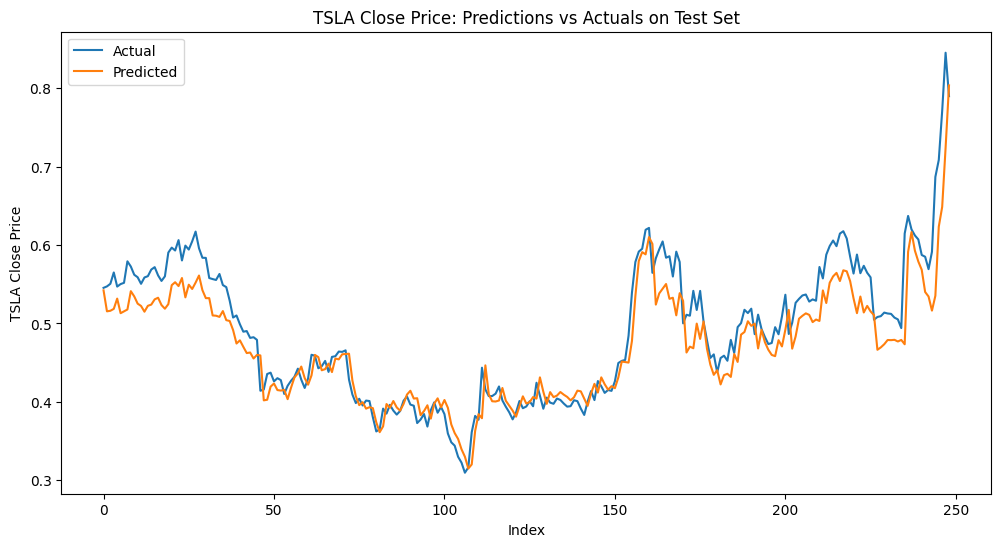

In [ ]:
model.eval()

# Predict on test data
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(test_actuals, label='Actual')
plt.plot(test_preds, label='Predicted')
plt.title('TSLA Close Price: Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('TSLA Close Price')
plt.legend()
plt.show()

Here we can see the predicted data follows the actual data with some differences. Parts of the prediction will later on in the timeseries have a less accurate predction of prices where there seems to be a uncaptured trend or a bias that maked increases smaller and decreases larger. From index 50 to 150 there is the best accuracy of the model that follows the actual data best with a very small offset in price.